# Miscellanea

In [1]:
import os
from pathlib import Path

# This is a terrible hack, and very unsafe
while not Path("config_data").exists():
    os.chdir("..")

In [2]:
print(os.getcwd())

/home/enrico/slim


In [3]:
from pathlib import Path
from slim.simulation.config import Config
from slim.simulation.simulator import Simulator, _get_simulation_path, load_artifact
import ray

def load_data(config_folder: str, sim_name: str, farms_per_process=1, **kwargs):
    quiet = kwargs.pop("quiet", False)
    orig_sim_name = sim_name
    sim_name = sim_name + "_" + str(kwargs)
    cfg_data_path = Path("config_data")
    cfg_data = cfg_data_path / "config.json"
    config_folder = cfg_data_path / config_folder
    outputs_path = Path("outputs") / orig_sim_name
    
    artifact = _get_simulation_path(outputs_path, sim_name)[0]
    print(artifact)
    if not artifact.exists():
        print(f"Artifact not yet generated, running {sim_name}")
        # defection_proba is farm-specific and needs special handling
        defection_proba = kwargs.pop("defection_proba", None)
        cfg = Config(cfg_data, config_folder, farms_per_process=farms_per_process, **kwargs)

        if defection_proba is not None:
            for farm in cfg.farms:
                farm.defection_proba = defection_proba
        
        sim = Simulator(outputs_path, sim_name, cfg)
        
        sim.run_model(quiet=quiet)
    return load_artifact(outputs_path, sim_name)

@ray.remote
def _launch(cfg_path, sim_name, **kwargs):
    return load_data(cfg_path, sim_name, **kwargs)
    
def generate_multiple_trials(config_folder: str, sim_name: str, **kwargs):
    seeds = [0, 42, 65535, 1e5, 1e30]
    tasks = [_launch.remote(config_folder, sim_name, quiet=True, seed=seed, **kwargs) for seed in seeds]
    return ray.get(tasks)
    #to_return = []
    #for seed in seeds:
    #    to_return.append(load_data(config_folder, sim_name, quiet=False, seed=seed, **kwargs))
    
    return to_return

In [4]:
trials = generate_multiple_trials("Fyne_complete", "Fyne_complete_bernoulli", treatment_strategy="bernoulli", defection_proba=2/10)
# trial = load_data("Fyne_complete", "Fyne_complete_bernoulli", treatment_strategy="bernoulli", defection_proba=2/10)

(_launch pid=143201) outputs/simulation_data_Fyne_complete_bernoulli_{'seed': 0, 'treatment_strategy': 'bernoulli', 'defection_proba': 0.2}.pickle.lz4
(_launch pid=143198) outputs/simulation_data_Fyne_complete_bernoulli_{'seed': 42, 'treatment_strategy': 'bernoulli', 'defection_proba': 0.2}.pickle.lz4
(_launch pid=143191) outputs/simulation_data_Fyne_complete_bernoulli_{'seed': 65535, 'treatment_strategy': 'bernoulli', 'defection_proba': 0.2}.pickle.lz4


In [5]:
#bernoullis = [load_data("Fyne_complete", f"Fyne_complete_bernoulli_{i/10}", treatment_strategy="bernoulli", defection_proba=i / 10)  for i in range(11)]

In [6]:
#mosaic = load_data("Fyne_complete", "Fyne_complete_mosaic", treatment_strategy="mosaic")

In [92]:
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

from slim.simulation.lice_population import LicePopulation, geno_to_alleles
from slim.simulation.config import Config
from slim.types.treatments import Treatment, treatment_to_class

# TODO: this is largely copied from plots.py but largely simplified due to a (thankfully) better API.

def prepare_ax(ax, farm_name, ylabel="Lice Population", yscale="log", ylim=(1, 1e10), threshold=None, legend=True):
    ax.set_title(farm_name, fontsize=18)
    ax.grid(True, axis='y')
    if ylim:
        ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel("Days", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if threshold:
        ax.axhline(threshold, linestyle="dashed", color="green", label="Controlled threshold")
    
    if legend:
        # avoid plottings dups
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        # ax.legend()

def get_treatment_regions(
    first_treatment_time, farm_df: pd.DataFrame
):
    # generate treatment regions
    # treatment markers
    #cm = pg.colormap.get("Pastel1", source="matplotlib", skipCache=True)
    #colors = cm.getColors(1)
    colors = cm.get_cmap("Pastel1")

    regions = []
    for treatment_idx in range(2):
        color = colors(treatment_idx, alpha=0.5)
        
        treatment_days_df = (
            farm_df[
                farm_df["current_treatments"].apply(
                    lambda l: bool(l[treatment_idx])
                )
            ]["timestamp"]
            - first_treatment_time
        )
        treatment_days = treatment_days_df.apply(lambda x: x.days).to_numpy()

        # Generate treatment regions by looking for the first non-consecutive treatment blocks.
        # There may be a chance where multiple treatments happen consecutively, on which case
        # we simply consider them as a unique case.
        # Note: this algorithm fails when the saving rate is not 1. This is not a problem as
        # precision is not required here.

        if len(treatment_days) > 0:
            treatment_ranges = []
            lo = 0
            for i in range(1, len(treatment_days)):
                if treatment_days[i] > treatment_days[i - 1] + 1:
                    range_ = (treatment_days[lo], treatment_days[i - 1])
                    #if range_[1] - range_[0] <= 2:
                    #    range_ = (range_[0] - 5, range_[0] + 5)
                    treatment_ranges.append(range_)
                    lo = i

            # since mechanical treatments are applied and effective for only one day we simulate a 10-day padding
            # This is also useful when the saving rate is not 1
            range_ = (treatment_days[lo], treatment_days[-1])
            #if range_[1] - range_[0] <= 2:
            #    range_ = (range_[0] - 5, range_[0] + 5)
            treatment_ranges.append(range_)

            regions.extend([(trange, treatment_idx, color) for trange in treatment_ranges])
    return regions

def plot_regions(ax, xs, regions):
    for region, treatment_idx, color in regions:
        label = treatment_to_class(Treatment(treatment_idx)).name + " treatment"
        if region[1] - region[0] <= 2:
            ax.axvline(region[0], 0, 1e20, linestyle=":", linewidth=3, label=label)
        else:
            ax.fill_between(xs, 0, 1e20, where=(region[0] <= xs) & (xs <= region[1]),
                        color=color, transform=ax.get_xaxis_transform(), label=label)

def get_trials(dfs, func, columns):
    total_per_df = []
    for df in dfs:
        total_per_df.append(func(df, columns))
    return pd.concat(total_per_df, axis=1)
    
def ribbon_plot(ax, xs, trials, label=""):
    min_interval = trials.min(axis=1)
    max_interval = trials.max(axis=1)
    mean_interval = trials.mean(axis=1)

    ax.plot(mean_interval, linewidth=2.5, label=label)
    ax.fill_between(xs, min_interval, max_interval, alpha=.3, label=label + " CI")
    
    for trial in trials:
        ax.plot(trial, linewidth=1.0, color='gray', alpha=0.8)

def plot_farm(farm_dfs, gross_ax, geno_ax, fish_ax, agg_ax, payoff_ax):
    farm_df = farm_dfs[0]
    stages = LicePopulation.lice_stages
    stages_readable= LicePopulation.lice_stages_bio_labels
    first_day = farm_df.iloc[0]["timestamp"]
    regions = get_treatment_regions(first_day, farm_df)
    xs = np.arange(len(farm_df))
    alleles = geno_to_alleles(0)

    # total population
    def agg(df, stages):
        return sum(df[stage].apply(lambda x: sum(x.values())) for stage in stages)
        
    total_per_df = get_trials(farm_dfs, agg, stages)
    
    ribbon_plot(gross_ax, xs, total_per_df, "Overall lice population")
    prepare_ax(gross_ax, "Lice population")
    
    plot_regions(gross_ax, xs, regions)

    """
    for stage in stages:
        per_geno = farm_df[stage]
        total = per_geno.apply(lambda x: sum(x.values()))
        prepare_ax(gross_ax, "By stage")
        gross_ax.plot(total, label=stages_readable[stage])
        plot_regions(gross_ax, xs, regions)
    """
    
    # Per allele
    def agg(df, col):
        return df[col[0]]

    for allele in alleles:
        total_per_df = get_trials(farm_dfs, agg, [allele])
        ribbon_plot(geno_ax, xs, total_per_df, label=allele)

    prepare_ax(geno_ax, "By geno", legend=True)
    
    plot_regions(geno_ax, xs, regions)
    
    # Fish population and aggregation
    def agg(df, col):
        return df[col[0]].apply(lambda x: sum(x) / len(x))
    
    farm_population = get_trials(farm_dfs, agg, ["fish_population"])
    farm_agg = get_trials(farm_dfs, agg, ["aggregation"])
    
    ribbon_plot(fish_ax, xs, farm_population, label="Fish population")
    plot_regions(fish_ax, xs, regions)
    
    prepare_ax(fish_ax, "By fish population",
               ylim=(0, 150000), yscale="linear")
    
    ribbon_plot(agg_ax, xs, farm_agg, label="Aggregation")
    plot_regions(agg_ax, xs, regions)
    
    prepare_ax(agg_ax, "By lice aggregation",
                    ylim=(0, 10), yscale="linear", threshold=6.0)
    
    prepare_ax(payoff_ax, "Payoff", ylim=(1, 1e7))
    payoff_ax.plot(farm_df.payoff.cumsum())
    plot_regions(payoff_ax, xs, regions)


def plot_data(dataframes, cfg: Config, title: str):
    dfs_per_farm = defaultdict(lambda: [])
    for df in dataframes:
        for x, y in df.reset_index().groupby("farm_id"):
            dfs_per_farm[x].append(y.reset_index())
    
    # lice-pop-agg    fish pop
    # lice-pop-stage  lice agg
    # farm payoff     
    width=26
    n = cfg.nfarms
    
    print(title) # TODO
    
    for i, (farm, farm_dfs) in enumerate(dfs_per_farm.items()):
        farm_name = cfg.farms[int(farm[len("farm_")])].name
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(width, 9/16 * width))
        fig.suptitle(farm_name, fontsize=30)
        payoff_fig = plt.figure(figsize=(width / 2, 9/32 * width)).subplots(1, 1)
        plot_farm(farm_dfs, axs[0][0], axs[0][1], axs[1][0], axs[1][1], payoff_fig)
        fig.savefig(f"outputs/{title} {farm_name}.pdf")
    
    plt.show()

bernoulli_0.2
<function plot_farm.<locals>.agg at 0x7f72145a5f70>
<function plot_farm.<locals>.agg at 0x7f72145a5f70>
<function plot_farm.<locals>.agg at 0x7f72145a5f70>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bd2af0>
<function plot_farm.<locals>.agg at 0x7f6f28bbbf70>
<function plot_farm.<locals>.agg at 0x7f6f28bbbf70>
<function plot_farm.<locals>.agg at 0x7f6f28bbbf70>
<function plot_farm.<locals>.agg at 0x7f6f28bbbf70>
<function plot_farm.<locals>.agg at 0x7f6f28bbbf70>
<function plot_farm.<locals>.agg at 0x7f6f28bbbf70>


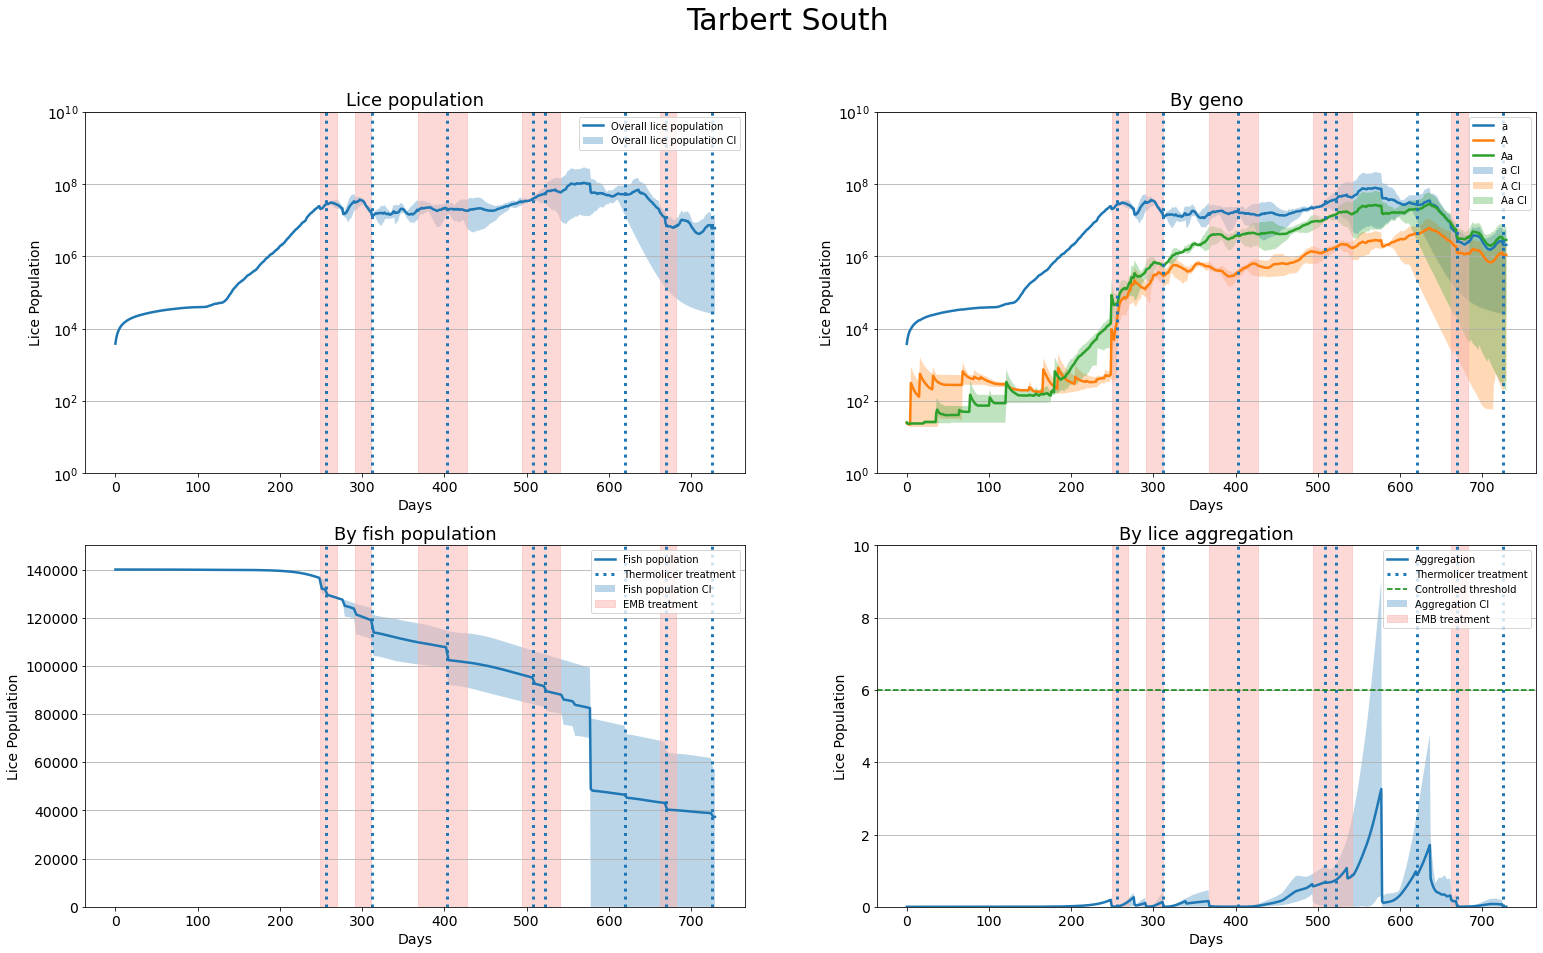

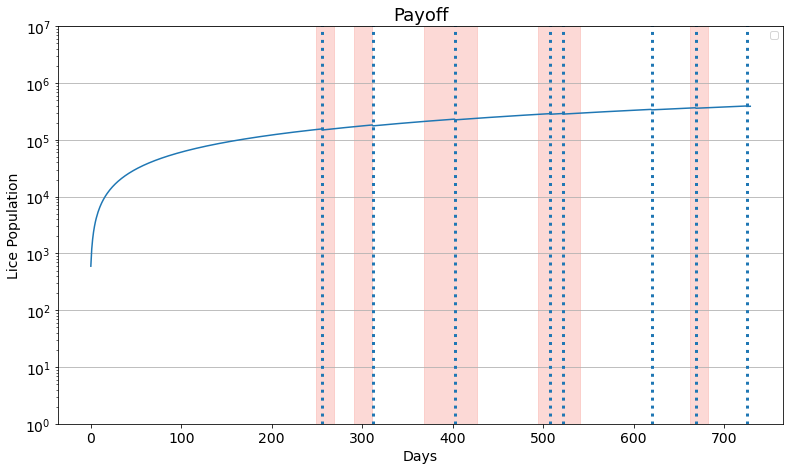

In [93]:
# config = Config("config_data/config.json", "config_data/Fyne_complete")

df = trials[0][0]
cfg = trials[0][2]
trial_dfs = [t[0] for t in trials]

plot_data(trial_dfs, cfg, "bernoulli_0.2")